In [1]:
#import packages
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage import measure
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import scipy.io as sio
from sklearn import mixture
import rasterio

In [2]:

#Open File with rasterio
file = rasterio.open(r'D:\Users\mjbattag\Documents\VernalPools\PA\PA_S2_VP_clip.tif')

#Read file as array
Y = file.read()

#Get file attributes
Y_attribs = file.profile

(484, 648, 3)
(484, 648, 3)
float64


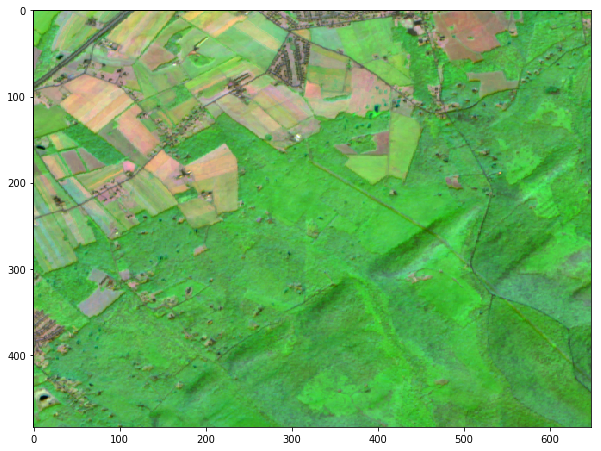

In [14]:
#prep file as array into correct format

C = np.rollaxis(Y[:],0,3)
C[C < 0] = 0
C[C > 10] = 10
#C = ma.masked_where(C == -3.402823e+38, C)
#C = ma.masked_where(C < -50, C)

#C = 10 * np.log10(C)


#scale and normalize data

print (C.shape)
D = C.astype('float64') 
G = D[:,:,0:3]
G[G < 0.05] = 0.05
G[G > .50] = .5
img = (G - np.min(G))
Gimg = img/(np.max(img))

print (Gimg.shape)
plt.figure(figsize=(10,10))
plt.imshow(Gimg)


print (Gimg.dtype)





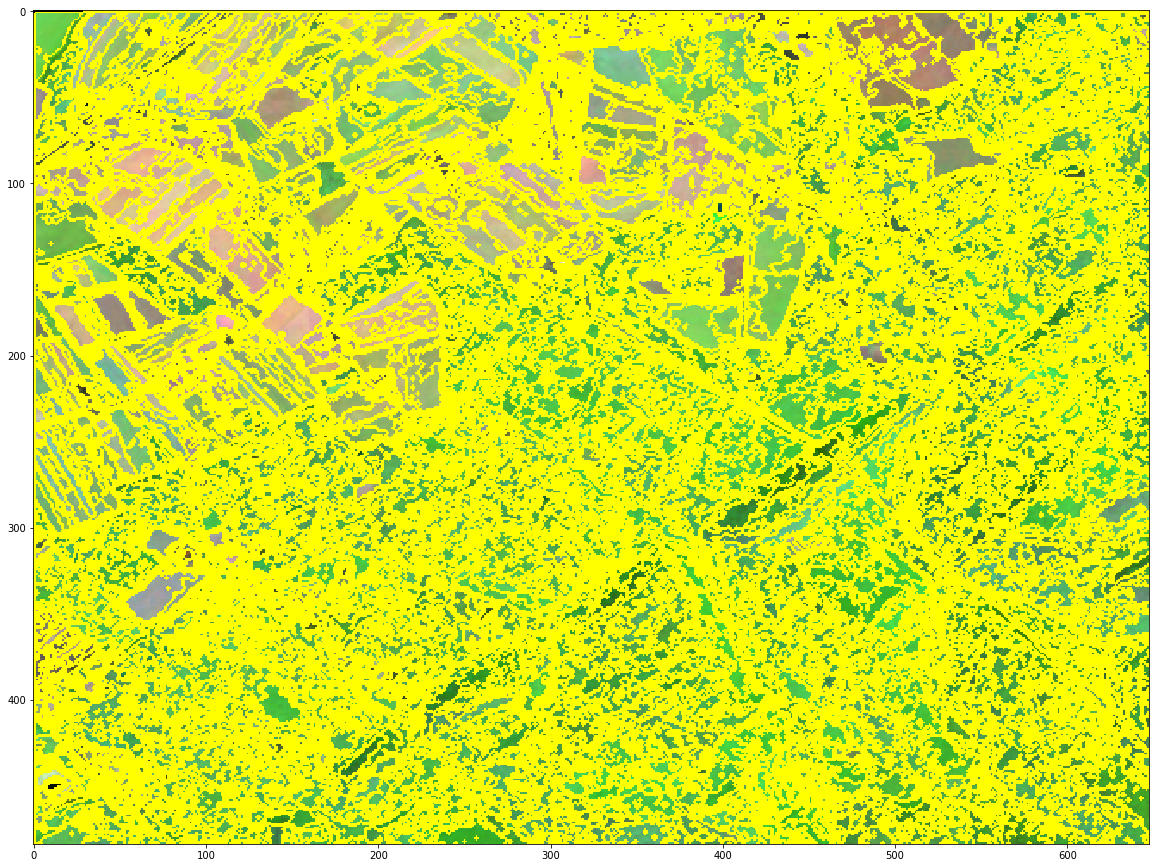

In [15]:
segments = slic(Gimg, compactness=.03, max_iter=25, n_segments = 1000, sigma = .1,spacing=None, multichannel=True, convert2lab=False, enforce_connectivity=False, min_size_factor=1, max_size_factor=3, slic_zero=False)
plt.figure(figsize=(20,20))
plt.imshow(mark_boundaries(Gimg, segments))
plt.show()


In [16]:
SP = D[:,:,0]
SU = D[:,:,1]
AU = D[:,:,2]

print (SP.shape)

(484, 648)


In [17]:
#calculate mean intensity for each segment
SPregions = measure.regionprops(segments, intensity_image=SP)
SPregion_means = [r.mean_intensity for r in SPregions]

SUregions = measure.regionprops(segments, intensity_image=SU)
SUregion_means = [r.mean_intensity for r in SUregions]

AUregions = measure.regionprops(segments, intensity_image=AU)
AUregion_means = [r.mean_intensity for r in AUregions]

In [18]:
SPintensityMask = np.ndarray(segments.shape)
SUintensityMask = np.ndarray(segments.shape)
AUintensityMask = np.ndarray(segments.shape)

# This performs "region_means" on a pixel-by-pixel basis
numRegions = (np.unique(segments)).size
for regionIndex in range(numRegions):
    cur_region_mask = (segments == regionIndex)# Pick out curent region
    cur_region_mean = np.mean( SP[cur_region_mask]) # Find median over that region
    SPintensityMask[cur_region_mask] = cur_region_mean # Assigns to each pixel in that region, the corresponding mean value
    
for regionIndex in range(numRegions):
    cur_region_mask = (segments == regionIndex)# Pick out curent region
    cur_region_mean = np.mean( SU[cur_region_mask]) # Find median over that region
    SUintensityMask[cur_region_mask] = cur_region_mean # Assigns to each pixel in that region, the corresponding mean value
    
for regionIndex in range(numRegions):
    cur_region_mask = (segments == regionIndex)# Pick out curent region
    cur_region_mean = np.mean( AU[cur_region_mask]) # Find median over that region
    AUintensityMask[cur_region_mask] = cur_region_mean # Assigns to each pixel in that region, the corresponding mean value

In [22]:
#output segmented data as raster
output2 = np.reshape(SPintensityMask, SP.shape).astype('float32')
Y_attribs.update(dtype='float32')
Y_attribs.update({'nodata': None})
Y_attribs.update({'count': 1})
#B.geocopy('/ws3/gis_lab/project/USFWS_GreatLakesMapping/Data/radarsat2/SurfaceWater/StClair/20170723_hv_segments.tif', output2, compress = True)
new_dataset2 = rasterio.open((r'D:\Users\mjbattag\Documents\VernalPools\PA\PA_S2_VP_clip_SP_Feb15.tif'), 'w', **Y_attribs)
new_dataset2.write(output2, 1)

In [ ]:
print (B_attribs)